In [1]:
import sys
sys.path.append("..")

from services.segments_database import select_chapter_words_by_score, update_chapter_topic, do_query
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
from beakerx import *
from time import time

import matplotlib
import matplotlib.pyplot as plt

## Settings

In [2]:
no_features = 1000
no_topics = 40
no_top_words = 10
no_top_documents = 2
min_score = 0
header_weight = 2
cluster_numbers = np.arange(5, 105, 5)

## Get Chapters and Texts

In [3]:
chapters = select_chapter_words_by_score(min_score)
df_chapters = pd.DataFrame(chapters.fetchall())
df_chapters.columns = chapters.keys()
df_chapters.head()

,chapter_id,text,chapter_number,header,header_preprocessed,parent_header,parent_preprocessed,grandparent_header,grandparent_preprocessed,document_id,preprocessed
0,1,\nStaatskanzlei\n\nRathaus 8750 Glarus\n\nTele...,None,\n,,,,,,7878,055 09 11 12 15 60 646 8750 fax glarus mail ra...
1,2,\nAusschreibungsgegenstand\n\nDer Kanton Glaru...,1,Ausschreibung; Arbeiten zur Installation und z...,ausschreibung arbeit installation betrieb elek...,,,,,7878,aktiv anforderung anforderungsbereich dabei do...
2,3,\nDer Regierungsrat will die elektronische Sti...,2,Ziele Projektziele:\n,ziel projektziel,,,,,7878,2018 2019 ausschreibung bund e elektronisch gl...
3,4,"\nEs wird vorausgesetzt, dass der Anbieter gen...",3,Marktpositionierung und Rolle des Anbieters\n,marktpositionierung rolle anbieters,,,,,7878,anbieter bereitstellung betrieb dass e genügen...
4,5,\nDie nachfolgende Grafik zeigt die Abgrenzung...,4,Systemabgrenzung\n,systemabgrenzung,,,,,7878,abgrenzung aktivität bestehen betreiben datens...


In [4]:
features = (df_chapters['header_preprocessed'] + " ").str.repeat(header_weight).str.lstrip() \
            + (df_chapters['parent_preprocessed'] + " ").str.repeat(header_weight).str.lstrip() \
            + (df_chapters['grandparent_preprocessed'] + " ").str.repeat(header_weight).str.lstrip() \
            + df_chapters['preprocessed']
features = features.str.strip()
features.head()

0    055 09 11 12 15 60 646 8750 fax glarus mail ra...
1    ausschreibung arbeit installation betrieb elek...
2    ziel projektziel ziel projektziel 2018 2019 au...
3    marktpositionierung rolle anbieters marktposit...
4    systemabgrenzung systemabgrenzung abgrenzung a...
dtype: object

## Calculate tf-idf

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features)
tfidf = tfidf_vectorizer.fit_transform(features)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## Calculate KMeans

In [6]:
models = []
tt = time()

for n_cluster in cluster_numbers: 
    print('STARTING TO CALCULATE MODEL WITH {} CLUSTERS'.format(n_cluster))
    km = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=10,
                verbose=False)
    t0 = time()
    km.fit(tfidf)
    print("done in %0.3fs" % (time() - t0))
    print('inertia {}'.format(km.inertia_))
    
    models.append({
        'model': km,
        'inertia': km.inertia_,
        'n_clusters': n_cluster
    })
    
print('FINISHED AFTER '.format(time() - tt))

STARTING TO CALCULATE MODEL WITH 5 CLUSTERS
done in 2022.895s
inertia 250931.4129676319
STARTING TO CALCULATE MODEL WITH 10 CLUSTERS
done in 2411.772s
inertia 246013.70840583585
STARTING TO CALCULATE MODEL WITH 15 CLUSTERS
done in 2582.489s
inertia 241887.36715636836
STARTING TO CALCULATE MODEL WITH 20 CLUSTERS
done in 2657.968s
inertia 238791.02455840324
STARTING TO CALCULATE MODEL WITH 25 CLUSTERS
done in 2547.078s
inertia 235279.09904278387
STARTING TO CALCULATE MODEL WITH 30 CLUSTERS
done in 2718.716s
inertia 232137.645807912
STARTING TO CALCULATE MODEL WITH 35 CLUSTERS
done in 2906.507s
inertia 229561.3311898539
STARTING TO CALCULATE MODEL WITH 40 CLUSTERS
done in 2505.930s
inertia 227118.28854409407
STARTING TO CALCULATE MODEL WITH 45 CLUSTERS
done in 2278.821s
inertia 224934.82037485178
STARTING TO CALCULATE MODEL WITH 50 CLUSTERS
done in 2240.664s
inertia 222497.72345674504
STARTING TO CALCULATE MODEL WITH 55 CLUSTERS
done in 2333.366s
inertia 222191.3167940473
STARTING TO CALC

## Plot Inertia

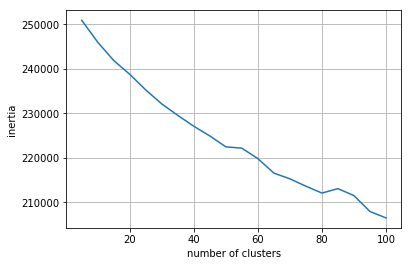

In [7]:
fig, ax = plt.subplots()
ax.plot([model['n_clusters'] for model in models], [model['inertia'] for model in models])

ax.set(xlabel='number of clusters', ylabel='inertia')
ax.grid()

plt.show()

## Find most important words

In [8]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

In [9]:
for i in range(40):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Cluster 0: los aufteilung bauauftrag beschaffungsobjekt vorsehen nein verschieden mehrere ausgeschrieben beschaffungen
Cluster 1: baustelle unternehmer bauleitung einzurechnen strassen zufahrt einheitspreis müssen gelten entsorgung
Cluster 2: vergabeverfahren angabe weit vertraulichkeit anbieter vertraulich bestimmung behandeln angebot verfahrenssprache
Cluster 3: einleitung zweck ausschreibungsunterlage form rahmenbedingung vorliegend dokument ausschreibung zielsetzung grundlage
Cluster 4: bauleitung unternehmer arbeit ag bauherrschaft dürfen architekt örtlich melden unternehmung
Cluster 5: begriffsdefinition ausmassbestimmung betreffend vergütungsregelung pos 200 000 gelten bedingung transport
Cluster 6: versicherung haftpflichtversicherung sachschaden pro administration versicherungsgesellschaft ereignis mio unternehmer chf
Cluster 7: total fr mwst 00 200 chf et netto 000 100
Cluster 8: leistungsfähigkeit wirtschaftlich finanziell technisch nachweis eignungskriterium anbieters ja ja